# LSN Exercise 10

In the same framework of the **Exercise 9**, we are going to implement a **Simulated Annealing (SA)** algorithm to solve again the **Travel Salesman Problem (TSP)** for the same configuration of cities. In addition, we are going to parallelize the **GA** of the previous exercise using **MPI libraries**, performing 4 independet searches of the optimal path over 4 different parallel processes, called *continents*, exchanging information through the best individuals.

In [1]:
# Settings and libraries:

import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)

# Input functions:

def Read(filename):
    with open(filename) as f:
        vector = [float(i) for i in f.read().splitlines()]
    return vector

# ------------------------------------------------------------

def Read_2_col(filename):
    
    a = []
    b = []
    
    with open(filename) as f:
        data = f.read().splitlines()
    
    for i in range(len(data)):
        data[i] = data[i].split()
        a.append(float(data[i][0]))
        b.append(float(data[i][1]))

    return a, b

# --------------------------------------------

## 10.1 TSP class and SA

We kept the same data-structure, methods and functions of the **Excercise 9**, i.e. the `TSP.h` and `TSP.cpp` files remain unchanged. In the *main code* we implemented the **SA algorithm**, following these steps:

- Set the number cities and create a first individual of the same size, called `Initial`;
- Save the initial configuration of cities in `Initial` and print it in `Initial.conf`;
- Define the *annealing schedule*, setting the starting temperature $T_{max}$, the cooling limit $T_{min}$, the cooling scale factor $scale$ and the number of steps for each temperature, $n_{step}$. Every new temperature is decreased by $scale$ times the previous one;
- For every temperature in the cicle define the *inverse temperature* $\beta = \frac{1}{T}$;
- Perform the following steps $n_{step}$ times for each temperature:

  - Save the old configuration in the new one;
  - Perform every tipe of mutation, each with the same probability $p = 25\%$;
  - Compute the cost function for the old configuration and the for the new one;
  - Accept the new configuration with probability proportional to the *Boltzmann weight*: $exp(-\beta(cost_{new} - cost_{old}))$;
  - If accepted, save the new configuration in the old one and store the quadratic distance of the new configuration;
  - If not, store the quadratic distance of the old configuration.
  
For both configurations we used the following values:

- *starting temperature*: $T_{max} = 100.0$;
- *cooling limit*: $T_{min} = 0.001$;
- *cooling scale factor*: $scale = \frac{T_{max}}{1000}$;
- *number of steps*: $n_{step} = 10^4$. 	

## 10.2 Circumference configuration

We present our results for $32$ cities randomly placed **on a circumference of unitary radius**. 

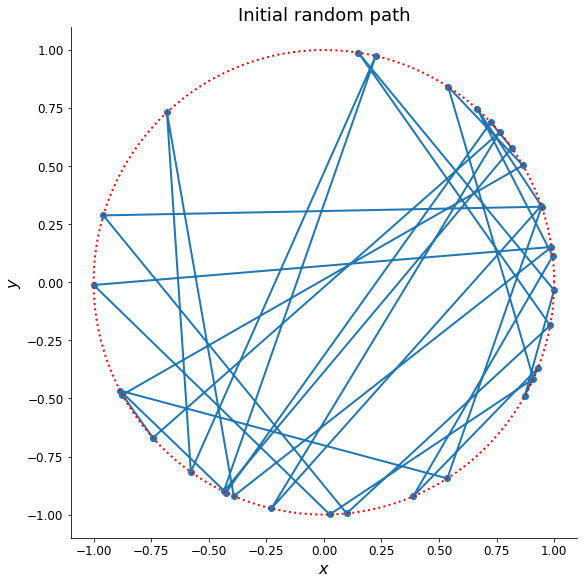

In [2]:
# Initial path with closure
x, y = Read_2_col("Circ/Initial.conf")
x.append(x[0])
y.append(y[0])

# Circumference
theta = np.linspace(0,2*np.pi,1000)
x_c = np.cos(theta)
y_c = np.sin(theta)

FIG_SIZE = (8,8)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_c, y_c, linestyle='dotted', color='red')
plt.title("Initial random path")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

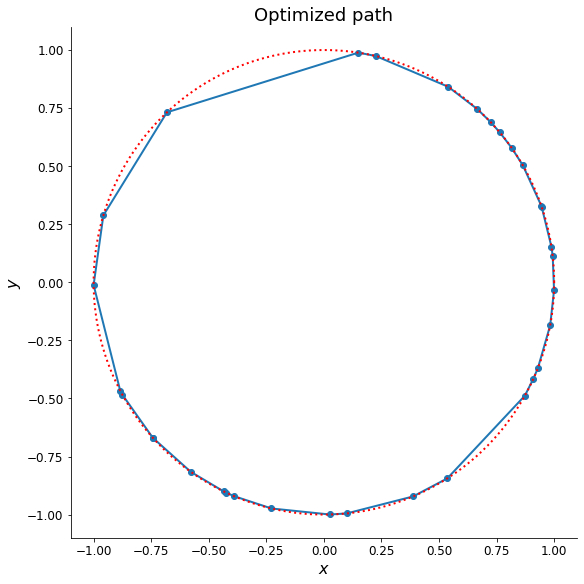

In [3]:
# Optimized path with closure
x, y = Read_2_col("Circ/Best.conf")
x.append(x[0])
y.append(y[0])

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_c, y_c, linestyle='dotted', color='red')
plt.title("Optimized path")
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.show()

------------------------------
Number of cooling steps =  110
------------------------------


/home/simone/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


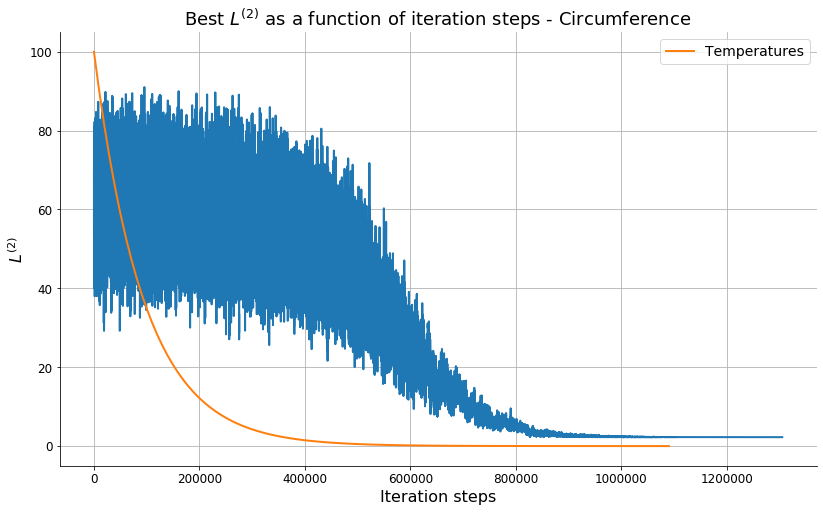

-----------------------------------------------------------------------
The best quadratic distance for the given configuration is: 2.26218
-----------------------------------------------------------------------


In [4]:
# Steps for each new temperature:
n_step = 10**4

L_best = Read("Circ/Distance.best")
temp = Read("Circ/Temperatures.dat")
N = [i for i in range(len(L_best))]
M = [n_step*i for i in range(len(temp))]

# Cooling steps:

print("------------------------------")
print("Number of cooling steps = ", len(temp))
print("------------------------------")

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best)
plt.plot(M, temp, label='Temperatures')
plt.title("Best $L^{(2)}$ as a function of iteration steps - Circumference")
plt.xlabel("Iteration steps")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------------")
print("The best quadratic distance for the given configuration is:", L_best[-1])
print("-----------------------------------------------------------------------")

The wider gap in the first part of the search (high temperaures range) and the gradual symmetrical thinning in the values of $L^{(2)}$ as the temperature drops down, is analogous to what we would expect for the energy values of a real physical system cooling down: hence the name of *simulated annealing*. 

## 10.3 Square configuration

We present our results for $32$ cities randomly placed **inside a square of unitary side length**. 

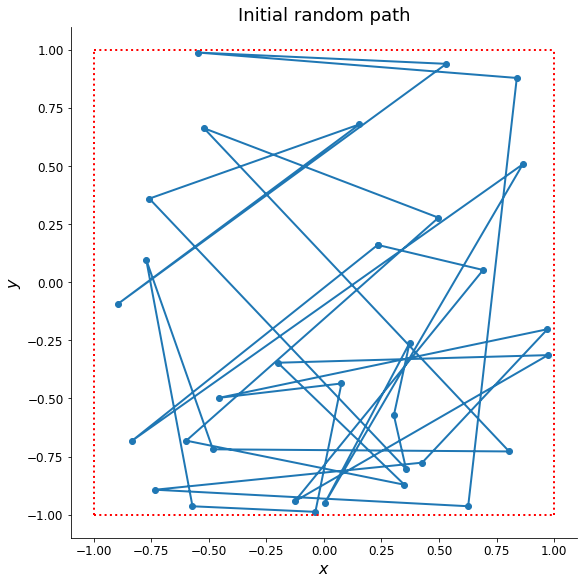

In [5]:
# Initial path with closure
x, y = Read_2_col("Square/Initial.conf")
x.append(x[0])
y.append(y[0])

# Square
x_left = [-1 for i in range(1000)]
x_right = [1 for i in range(1000)]
y_up = x_right
y_down = x_left
line = np.linspace(-1,1,1000)

FIG_SIZE = (8,8)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_left, line, linestyle='dotted', color='red')
plt.plot(x_right, line, linestyle='dotted', color='red')
plt.plot(line, y_up, linestyle='dotted', color='red')
plt.plot(line, y_down, linestyle='dotted', color='red')
plt.title("Initial random path")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

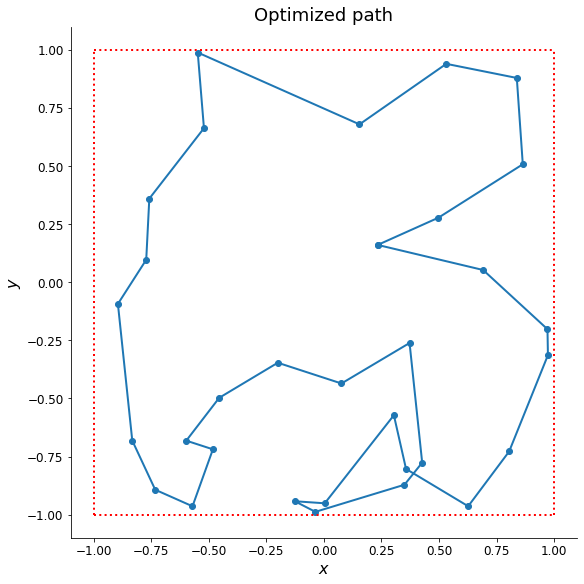

In [6]:
# Optimized path with closure
x, y = Read_2_col("Square/Best.conf")
x.append(x[0])
y.append(y[0])

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_left, line, linestyle='dotted', color='red')
plt.plot(x_right, line, linestyle='dotted', color='red')
plt.plot(line, y_up, linestyle='dotted', color='red')
plt.plot(line, y_down, linestyle='dotted', color='red')
plt.title("Optimized path")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

------------------------------
Number of cooling steps =  110
------------------------------


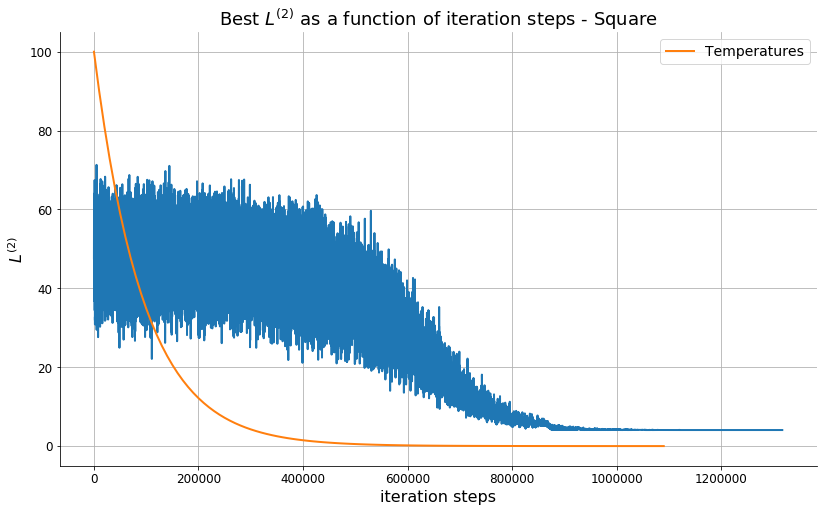

-----------------------------------------------------------------------
The best quadratic distance for the given configuration is: 4.07119
-----------------------------------------------------------------------


In [7]:
L_best = Read("Square/Distance.best")
temp = Read("Square/Temperatures.dat")
N = [i for i in range(len(L_best))]
M = [n_step*i for i in range(len(temp))]

# Cooling steps:

print("------------------------------")
print("Number of cooling steps = ", len(temp))
print("------------------------------")

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best)
plt.plot(M, temp, label='Temperatures')
plt.title("Best $L^{(2)}$ as a function of iteration steps - Square")
plt.xlabel("iteration steps")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------------")
print("The best quadratic distance for the given configuration is:", L_best[-1])
print("-----------------------------------------------------------------------")

The results obtained are very similar to those of the GA approach, but *the GA stil performs better*, because:
- The computational effort is lower: in the square configuration case we used $n_{gen} \times n_{step} = n_{gen} \times \frac{n_{ind}}{2} = 500 \times 250 = 1.25 \times 10^5$ total MC steps, to be compared with $n_{cool} \times n_{step} = 110 \times 10^4 = 1.1 \times 10^6$ MC steps;
- The GA was able to find a shorter path for the square configuration.

## 10.4 MPI parallelization

Comparing the the *SA approach* and the *GA approach* from **Exercise 9** we saw that, for complex configurations like the square one, *the best results are achieved using GA*. We want to *parallelize* our GA code, in order to explore more widely the *space of possible solutions* and reach a *lower local minimum*. The idea is to add the possibility of simulating *many* generations simultaneously, in the so called *continents*: each of them is an *indipendent executional unit*, but sharing the *same addres space*; this allows to build a *single program* using *multiple data* and to make the processes communicate with each other: *every $n_{mig}$ we can exchange the two best individuals of two randomly selected continents!*

To parallelize our code, we use the **MPI** stadard, following these steps:

- We use the same `TSP.h` and `TSP.cpp` files;
- We modify the makefile in order to compile with `mpicxx`;
- We take the main code of **Exercise 9**, including the `mpi.h` library, the *main* arguments and "wrapping" the entire code with the standard initialization and finalization declarations of MPI:

	```
    // MPI INITIALIZATION -----------------
    int size, rank;
    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
	// ------------------------------------
    
    ...
    PARALLELIZED CODE
    ...
    
    MPI_Finalize();
    
    ```
- We initialize our random number generator with the usual instructions, *but* with a fundamental change: we read a different line of the file `primes` for each different *rank* == *continent*;
- We generate the desidered configuration inside the *rank 0*, we "freeze" the other ranks using `MPI_Barrier(MPI_COMM_WORLD)`, and then we communicate it to all the other ranks using `MPI_Bcast(...)`: this allow us to have a single initial configuration although with *rnd objects* initialized with different seeds;
- We generate the first population in every *continent* == *rank*, and we sort it;
- We define:

    ```
	// MPI TAGS-STATUS to send and receive
	int tag_x = 1;
	int tag_y = 2;
	MPI_Status stat;
	// -----------------------------------
    ```
  To send and receive messages;
- We start our GA, which is different from the old one only in the *migration algorithm*, performend every $n_{mig}$ generations. **This algorithm is fully commented on the C++ code itself**, but we underline an important **concept** and one important **difficulty**:

  - **concept**: before making the exchange between two continents using `MPI_Send(...)` and `MPI_Recv(...)` with appropriate *tags* to recognize *soruces* and *destinations*, we must choose two continets randomly between the *size* available. In order to do that, we use the same trick implemented for building the same initial configuration of cities: we generate two random integers (the continents' tag) inside the *rank 0* and then we make them visible to all the other processes using `MPI_Bcast(...)`;
  - **difficulty**: We have to use support double pointers to save the (x,y) coordinates of the best individual, because MPI works only with POD (Plain Old Data).
  
- We print the optimal configuration and the quadratic distance cost for the best individual for every generation of every continent, using different file names for each rank.

In what follows we present our results for **4 continents** (run the program using `mpiexec -np 4 exercise10_Parallel.exe`), $n_{gen} = 500$ and $n_{ind} = 500$, and with the same *bias* and *crossover/mutation probabilities* of the **Exercise 9**, in order to enstablish a comparison between the results. We adopted different values of $n_{mig}$: for every $n_{mig}$ value we show the best quadratic distance trend as a function of generations for every continent. In the end we present the optimal paths for the value of $n_{mig}$ giving the the minimal cost function.

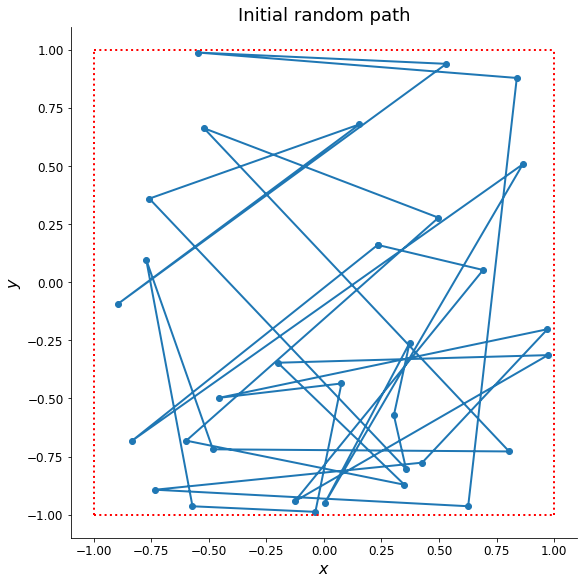

In [8]:
# Initial path with closure
x, y = Read_2_col("Parallel_Search/Adamo.conf")
x.append(x[0])
y.append(y[0])

FIG_SIZE = (8,8)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(x, y, marker='o')
plt.plot(x_left, line, linestyle='dotted', color='red')
plt.plot(x_right, line, linestyle='dotted', color='red')
plt.plot(line, y_up, linestyle='dotted', color='red')
plt.plot(line, y_down, linestyle='dotted', color='red')
plt.title("Initial random path")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

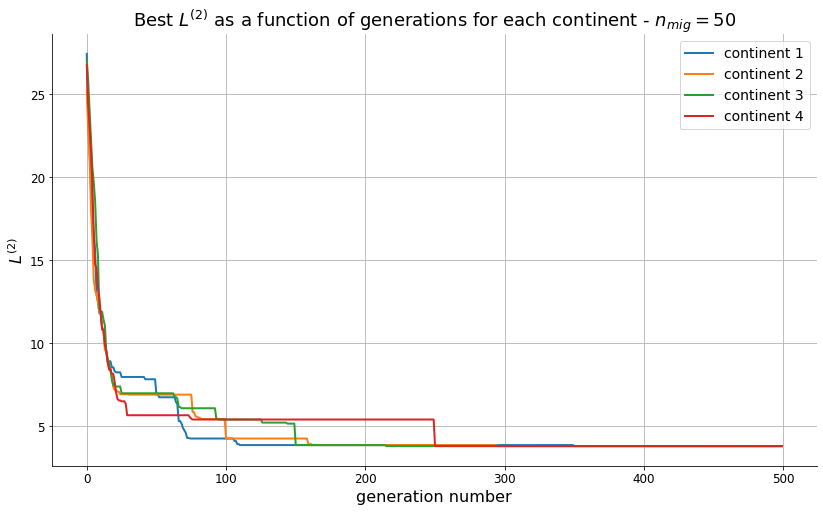

-----------------------------------------------------------------
The best quadratic distance for the continent 1 is: 3.79891
The best quadratic distance for the continent 2 is: 3.79891
The best quadratic distance for the continent 3 is: 3.79335
The best quadratic distance for the continent 4 is: 3.79891
-----------------------------------------------------------------


In [9]:
L_best_1 = Read("Parallel_Search/mig_50/Distance_1.best")
L_best_2 = Read("Parallel_Search/mig_50/Distance_2.best")
L_best_3 = Read("Parallel_Search/mig_50/Distance_3.best")
L_best_4 = Read("Parallel_Search/mig_50/Distance_4.best")
N = [i for i in range(len(L_best_1))]

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best_1, label='continent 1')
plt.plot(N, L_best_2, label='continent 2')
plt.plot(N, L_best_3, label='continent 3')
plt.plot(N, L_best_4, label='continent 4')
plt.title("Best $L^{(2)}$ as a function of generations for each continent - $n_{mig} = 50$")
plt.xlabel("generation number")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------")
print("The best quadratic distance for the continent 1 is:", L_best_1[-1])
print("The best quadratic distance for the continent 2 is:", L_best_2[-1])
print("The best quadratic distance for the continent 3 is:", L_best_3[-1])
print("The best quadratic distance for the continent 4 is:", L_best_4[-1])
print("-----------------------------------------------------------------")

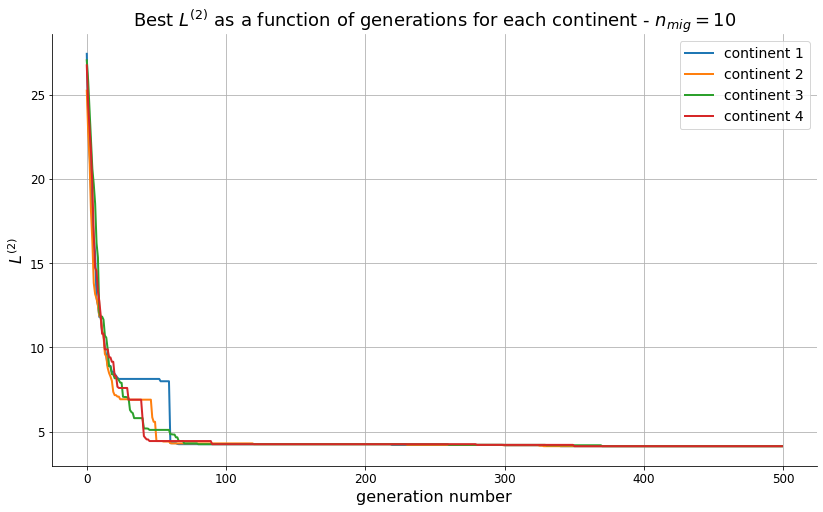

-----------------------------------------------------------------
The best quadratic distance for the continent 1 is: 4.13701
The best quadratic distance for the continent 2 is: 4.13701
The best quadratic distance for the continent 3 is: 4.13701
The best quadratic distance for the continent 4 is: 4.13701
-----------------------------------------------------------------


In [10]:
L_best_1 = Read("Parallel_Search/mig_10/Distance_1.best")
L_best_2 = Read("Parallel_Search/mig_10/Distance_2.best")
L_best_3 = Read("Parallel_Search/mig_10/Distance_3.best")
L_best_4 = Read("Parallel_Search/mig_10/Distance_4.best")
N = [i for i in range(len(L_best_1))]

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best_1, label='continent 1')
plt.plot(N, L_best_2, label='continent 2')
plt.plot(N, L_best_3, label='continent 3')
plt.plot(N, L_best_4, label='continent 4')
plt.title("Best $L^{(2)}$ as a function of generations for each continent - $n_{mig} = 10$")
plt.xlabel("generation number")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------")
print("The best quadratic distance for the continent 1 is:", L_best_1[-1])
print("The best quadratic distance for the continent 2 is:", L_best_2[-1])
print("The best quadratic distance for the continent 3 is:", L_best_3[-1])
print("The best quadratic distance for the continent 4 is:", L_best_4[-1])
print("-----------------------------------------------------------------")

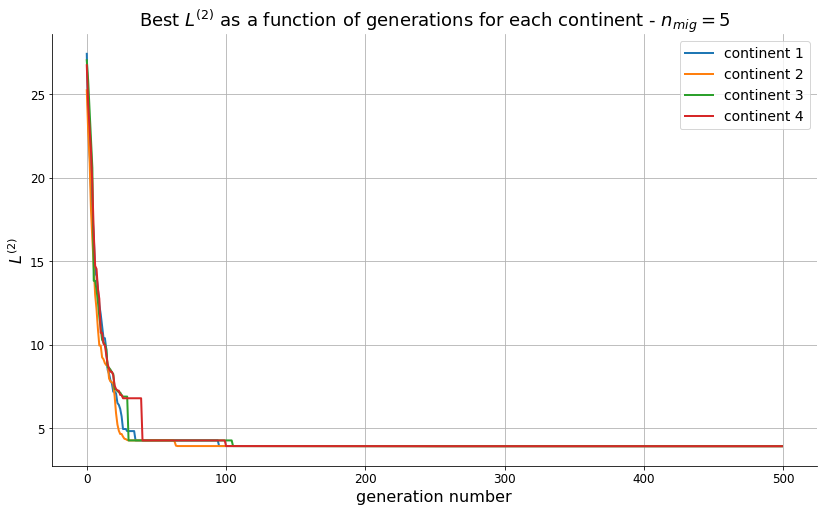

-----------------------------------------------------------------
The best quadratic distance for the continent 1 is: 3.91886
The best quadratic distance for the continent 2 is: 3.91886
The best quadratic distance for the continent 3 is: 3.91886
The best quadratic distance for the continent 4 is: 3.91886
-----------------------------------------------------------------


In [11]:
L_best_1 = Read("Parallel_Search/mig_5/Distance_1.best")
L_best_2 = Read("Parallel_Search/mig_5/Distance_2.best")
L_best_3 = Read("Parallel_Search/mig_5/Distance_3.best")
L_best_4 = Read("Parallel_Search/mig_5/Distance_4.best")
N = [i for i in range(len(L_best_1))]

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best_1, label='continent 1')
plt.plot(N, L_best_2, label='continent 2')
plt.plot(N, L_best_3, label='continent 3')
plt.plot(N, L_best_4, label='continent 4')
plt.title("Best $L^{(2)}$ as a function of generations for each continent - $n_{mig} = 5$")
plt.xlabel("generation number")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------")
print("The best quadratic distance for the continent 1 is:", L_best_1[-1])
print("The best quadratic distance for the continent 2 is:", L_best_2[-1])
print("The best quadratic distance for the continent 3 is:", L_best_3[-1])
print("The best quadratic distance for the continent 4 is:", L_best_4[-1])
print("-----------------------------------------------------------------")

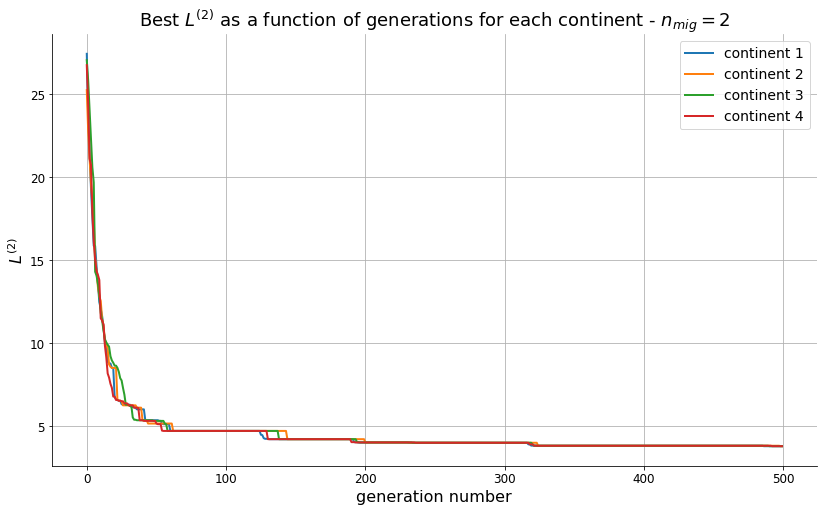

-----------------------------------------------------------------
The best quadratic distance for the continent 1 is: 3.79335
The best quadratic distance for the continent 2 is: 3.79335
The best quadratic distance for the continent 3 is: 3.79335
The best quadratic distance for the continent 4 is: 3.79335
-----------------------------------------------------------------


In [12]:
L_best_1 = Read("Parallel_Search/mig_2/Distance_1.best")
L_best_2 = Read("Parallel_Search/mig_2/Distance_2.best")
L_best_3 = Read("Parallel_Search/mig_2/Distance_3.best")
L_best_4 = Read("Parallel_Search/mig_2/Distance_4.best")
N = [i for i in range(len(L_best_1))]

SCALE = 7
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(N, L_best_1, label='continent 1')
plt.plot(N, L_best_2, label='continent 2')
plt.plot(N, L_best_3, label='continent 3')
plt.plot(N, L_best_4, label='continent 4')
plt.title("Best $L^{(2)}$ as a function of generations for each continent - $n_{mig} = 2$")
plt.xlabel("generation number")
plt.ylabel("$L^{(2)}$")
plt.legend()
plt.grid()
plt.show()

# Best path cost
print("-----------------------------------------------------------------")
print("The best quadratic distance for the continent 1 is:", L_best_1[-1])
print("The best quadratic distance for the continent 2 is:", L_best_2[-1])
print("The best quadratic distance for the continent 3 is:", L_best_3[-1])
print("The best quadratic distance for the continent 4 is:", L_best_4[-1])
print("-----------------------------------------------------------------")

*The results are very similar to the one obtained using the serial GA code*. Performing frequent migrations between continents ($n_{mig} = 2$) we obtained a slightly better configuration, shown below. A more detailed analysis would require to study the execution time as a function of the number of migrations, comparing it with execution time of the serial code, with the other parameters set equally.

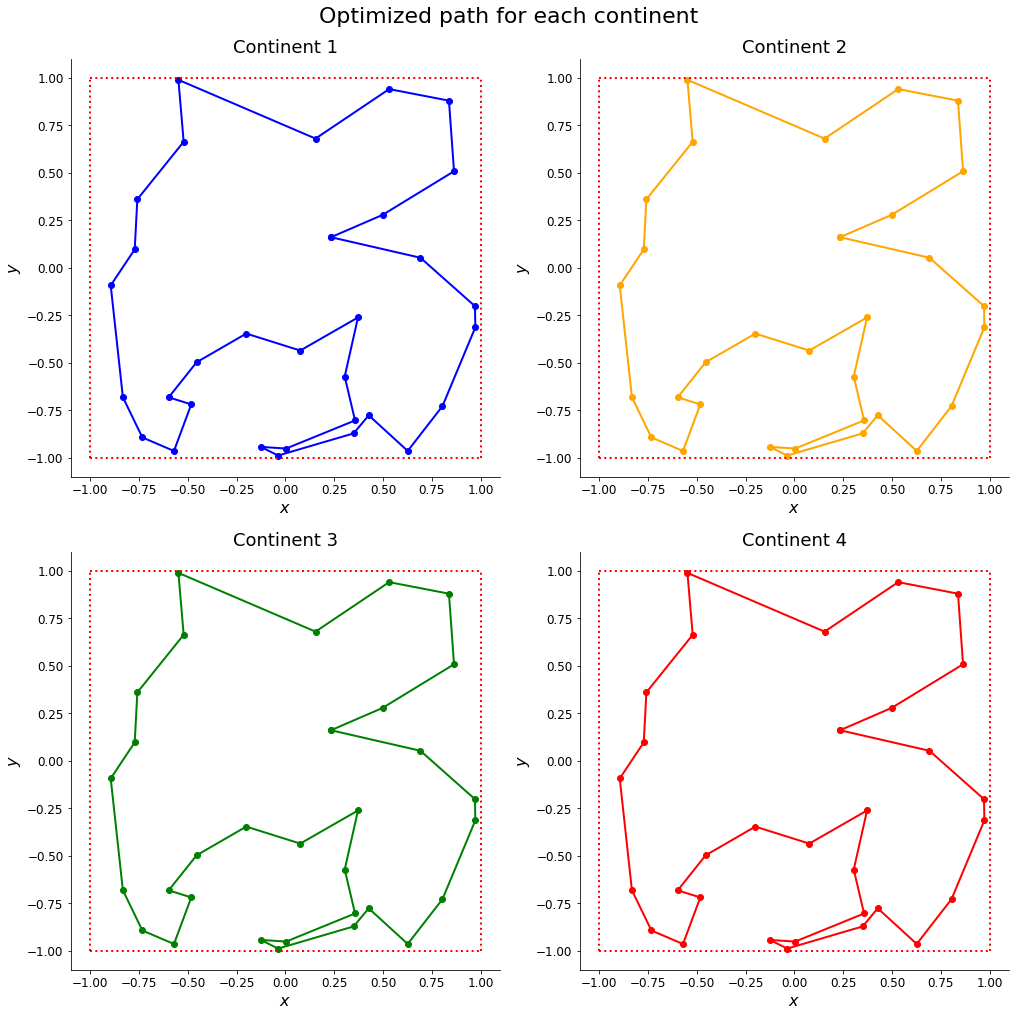

In [13]:
# Optimized paths for each continent:
x_1, y_1 = Read_2_col("Parallel_Search/mig_2/Best_1.conf")
x_1.append(x_1[0])
y_1.append(y_1[0])

x_2, y_2 = Read_2_col("Parallel_Search/mig_2/Best_2.conf")
x_2.append(x_2[0])
y_2.append(y_2[0])

x_3, y_3 = Read_2_col("Parallel_Search/mig_2/Best_3.conf")
x_3.append(x_3[0])
y_3.append(y_3[0])

x_4, y_4 = Read_2_col("Parallel_Search/mig_2/Best_4.conf")
x_4.append(x_4[0])
y_4.append(y_4[0])

FIG_SIZE = (14,14)
fig, ((path_1, path_2), (path_3, path_4)) = plt.subplots(2, 2, figsize=FIG_SIZE, constrained_layout=True)
fig.suptitle("Optimized path for each continent", fontsize=22)

path_1.plot(x_1, y_1, marker='o', color='blue')
path_1.set_title("Continent 1")
path_2.plot(x_2, y_2, marker='o', color='orange')
path_2.set_title("Continent 2")
path_3.plot(x_3, y_3, marker='o', color='green')
path_3.set_title("Continent 3")
path_4.plot(x_4, y_4, marker='o', color='red')
path_4.set_title("Continent 4")

for i in fig.get_axes():
    i.plot(x_left, line, linestyle='dotted', color='red')
    i.plot(x_right, line, linestyle='dotted', color='red')
    i.plot(line, y_up, linestyle='dotted', color='red')
    i.plot(line, y_down, linestyle='dotted', color='red')
    i.set_xlabel('$x$')
    i.set_ylabel('$y$')